# Building a CNN Classifier with PyTorch: Part 1 

In this tutorial, we will walk through the basic components of building a CNN classifier with PyTorch.  We will be using data from [Design Safe](https://www.designsafe-ci.org/) in this tutorial:

"DesignSafe is a comprehensive cyberinfrastructure that is part of the NSF-funded Natural Hazard Engineering Research Infrastructure (NHERI) and provides cloud-based tools to manage, analyze, understand, and publish critical data for research to understand the impacts of natural hazards." -- About Design Safe


<center><img src=Image/DesignSafeLogo.png /></center>

We will use a DesignSafe dataset from Hurricane Harvey, a category 4 hurricane that hit Texas in August of 2017 and resulted in catastrophic flooding to the Houston metropolitan area. The data set is specifically focused on image classification of homes according to the amount of damage the home received. All images of homes are labeled as C0, C2, or C4 respectively for low, medium or high damage.

<center><img src=Image/pytorch_logo.png /></center>

Pytorch is a popular machine learning library for building deep learning models developed by Facebook.  The basics of building a CNN model with Pytorch can be broken down into the following components:

- Dataset Loaders and Transforms
- Building the Neural Network
- Training the Neural Network

Let's get started by importing the modules we need for this notebook as well as set a few hyperparameters needed throughout the notebook. Then, we will dive into the basics of dataset loaders and transforms. 

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

torch.hub.set_dir('/tmp') # remove when not running here 

This notebook will use the following hyperparameters:

- Learning Rate (lr): how much model parameters are updated at each batch/epoch
- Batch Size: number of data points used to estimate gradients at each iteration
- Epochs: Number of times to iterate over our entire dataset in optimization process

These hyperparameters will be used throughout the notebook and are defined below. 

In [2]:
hp = {"lr":1e-4, "batch_size":16, "epochs":5}

## Dataset Loaders and Transforms

Loading, transforming and preparing data for building deep learning can be messy and difficult to maintain.  Pytorch provides tools to ease this effort and decouples it from the training portion of your machine learning pipeline. Below summarizes the three Pytorch tools we will highlight in this demo: 

- Dataset: stores data and their corresponding labels
- Transforms: performs data manipulation to make data suitable for training
- DataLoaders: iterable around the dataset for ease of access to samples from the dataset.

Let's dive into each of these components and load our design safe dataset.

### Downloading dataset
We first need to get our data set 

In [3]:
! cp -r /scratch1/00946/zzhang/design-safe-tutorial/data.tar.gz /tmp/
! tar zxf /tmp/data.tar.gz -C /tmp
! ls /tmp/Dataset_2
! rm /tmp/data.tar.gz

Train  Validation


Next, let's define the path to out train and validation sets based on the structure of the downloaded data.

In [4]:
train_path, val_path,test_path = "/tmp/Dataset_2/Train/", "/tmp/Dataset_2/Validation/", None

### Dataset and Transforms

Next, we set up a function to load our data and subsequently perform needed transforms.  This functions uses a few tools that exist within torchvision.  

#### Dataset

`torchvision.datasets.ImageFolder` is a generic data loader where images are structured as follows:

```
path_to_data/C0/**.png
path_to_data/C2/**.png
path_to_data/C4/**.png
```

Note the directories C0, C2, and C4 are the names of the three classes in our classifier and, in this case, refer to low, medium and high levels of damage. Another noteworthy feature of torchvision's datasets is that images are not immediately loaded into memory.  They are loaded one by one as needed. 

#### Transforms

`torchvision.transforms.Compose` applies a series of transformations to your data. In our function, we use Compose to perform a series of two transforms:

- `torchvision.transforms.Resize` which resizes your image to the specified dimension
- `torchvision.transofrms.ToTensor` converts you images from PIL or numpy arrrays to a torch tensor. 

In the function below, we use `ImageFolder` to load our train, validation and testing data and perform the needed transformations as described above.

In [5]:
def load_datasets(train_path, val_path, test_path):
  img_transform = transforms.Compose([transforms.Resize((244,244)),transforms.ToTensor()])
  train_dataset = datasets.ImageFolder(train_path, transform=img_transform)
  val_dataset = datasets.ImageFolder(val_path, transform=img_transform) 
  test_dataset = datasets.ImageFolder(test_path, transform=img_transform) if test_path is not None else None
  print(f"Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
  return train_dataset, val_dataset, test_dataset

In [6]:
train_set, val_set, test_set = load_datasets(train_path, val_path, test_path)

Train set size: 1322, Validation set size: 363


### Construct Dataloaders 

As mentioned above, Pytorch's dataset features load images one by one. When training deep learning models, we typically use a batch gradient descent algorithm to optimize our network and thus we will need to load random images in our specified batch sizes at each gradient descent step. Pytorch's DataLoader is an iterable that automatically performs and loads the data need at each iteration via a simple API.  In the function, we instantiate the DataLoader for our train, test and validation datasets.  

In [7]:
def construct_dataloaders(train_set, val_set, test_set, batch_size, shuffle=True):
  train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle)
  val_dataloader = torch.utils.data.DataLoader(val_set, batch_size) 
  test_dataloader = torch.utils.data.DataLoader(test_set, batch_size) if test_path is not None else None
  return train_dataloader, val_dataloader, test_dataloader

In [8]:
train_dataloader, val_dataloader, test_dataloader = construct_dataloaders(train_set, val_set, test_set, hp["batch_size"], True)

### Visualizing the Design Safe Dataset

Before we move on to building the architecture of our CNN model, let's visualize some of our design safe dataset.  

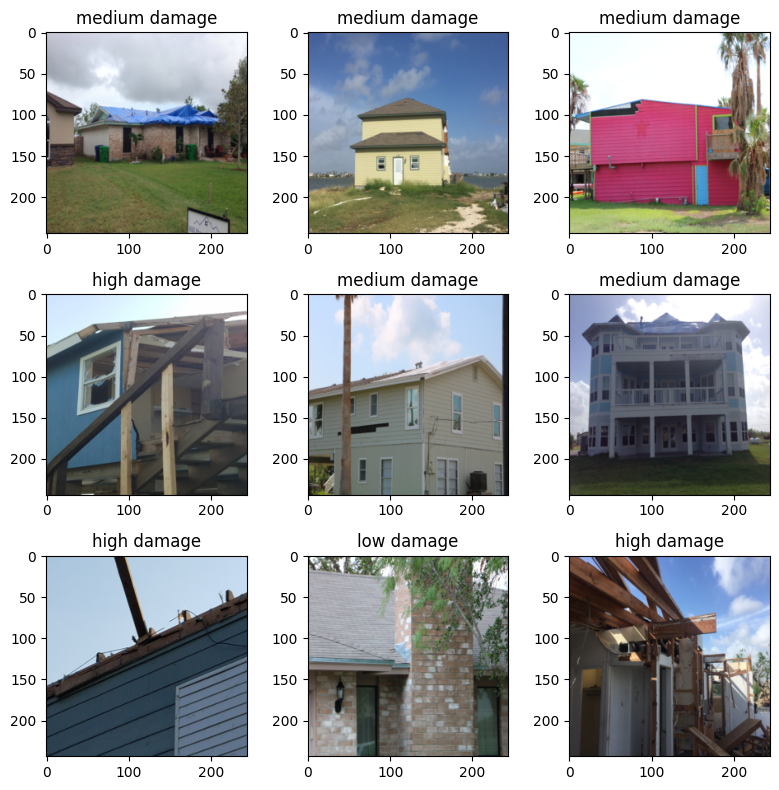

In [9]:
fig,axs = plt.subplots(3,3,figsize=(8, 8))
label_map={0: 'low damage', 1:'medium damage', 2:'high damage'}
for ax in axs.ravel():
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    ax.imshow(img.permute(1, 2, 0)) #.reshape((244,244,3)))
    ax.set_title(label_map[label])
fig.tight_layout()

As we can see above, our dataset contains images of houses post Hurricane Harvey.  Each of these images has been labeled as having low, medium, or high levels of damage.  

## Building the Neural Network

Next, we need to build the architecture of our CNN classfier.  In this tutorial, we will utilize transfer learning.  It is rare for people to build CNN from scratch as we can leverage a CNN model that was trained with very large datasets and apply that knowledge to our use case as is done in transfer learning.  

### ResNet
In this tutorial we will start with the resnet18 model trained with the ImageNet dataset.  Below we instantiate this model and load the pretrained weights. 

In [10]:
resnet = models.resnet18(weights="IMAGENET1K_V1")    

### Transfer Learning

With transfer learning there are two common ways we can utilize previously optimized weights for specific CNN architectures:

- Start the optimization process of model at the previously optimized weight instead of random weights.  This will accelerate the training process of the entire network.
- Use the previously optimized weights as a fixed feature extractor.  That is, we freeze the previously learned weights except that of the last fully connected layers.  

In this tutorial, we will use ResNet18 as a fixed feature extractor.  Let's start by freezing all the weights in our network:

In [11]:
for param in resnet.parameters():
    param.requires_grad = False 

Note, if we wanted to fine tune our entire model, we could skip the above step. 

Then, we can add a new final fully connected layer.  These parameters will, by default in Pytorch, not be frozen when we replace the final fully connected layers and will be learned in the training process. 

In [12]:
# print last fully connected layer
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
# get the input dimension for this layer
num_ftrs = resnet.fc.in_features

# build the new final fully connected layers of network
fc = nn.Sequential(
      nn.Linear(num_ftrs, num_ftrs),
      nn.ReLU(),
      nn.Linear(num_ftrs, 3)
    )

# replace final fully connected layer
resnet.fc = fc

## Training the Neural Network

### Define Loss Function and Optimizer

Now that we have our dataloaders set up and are model architecture built, we are ready to train our model.  To train the model, we need to set up a loss function and an optimizer to optimize that loss function.  Below we instantiate the Cross Entropy Loss function and the Adam optimizer. 


In [14]:
opt = torch.optim.Adam(resnet.parameters(),lr=hp["lr"])
loss_fn = nn.CrossEntropyLoss()

Note that we are using the learning rate hyperparameter specified at the the top of this notebook.

In [15]:
hp

{'lr': 0.0001, 'batch_size': 16, 'epochs': 5}

### Train and Model Evaluation Functions

Finally, we need to define standard pytorch train and evaluation functions.  The function `train` iterates over multiple epochs and all batches of data in each epoch.  Model parameters are updated for each batch with the given loss function and optimizer.  The model accuracy and loss is computing with testing data at every epoch.

In [16]:
@torch.no_grad()
def eval_model(data_loader, model, loss_fn, DEVICE):
  model.eval()
  loss, accuracy = 0.0, 0.0
  n = len(data_loader)

  for i, data in enumerate(data_loader):
    x,y = data
    x,y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    loss += loss_fn(pred, y)/len(x)
    pred_label = torch.argmax(pred, axis = 1)
    accuracy += torch.sum(pred_label == y)/len(x)
    
  return loss/n, accuracy/n 

def train(train_loader, val_loader, model, opt, loss_fn, epochs, DEVICE):
  n = len(train_loader)

  for epoch in range(epochs):
    model.train(True)
    count = 0
    avg_loss, avg_acc = 0.0, 0.0
    count = 0
    print(f"Epoch {epoch+1}/{epochs}:")
    start_time = datetime.now()
    for x, y in train_loader:
      x, y = x.to(DEVICE), y.to(DEVICE) # move data to gpu
      pred = model(x)                   # compute model prediction
      loss = loss_fn(pred,y)            # compute model loss
      # backpropogation
      opt.zero_grad()                   # reset gradient calculations
      loss.backward()                   # compute gradients
      opt.step()                        # update model parameters via optimization step
      avg_loss += loss
      pred_label = torch.argmax(pred, axis=1)
      avg_acc += torch.sum(pred_label == y)/len(x)
        
    end_time = datetime.now()
    print(f"Time: {(end_time-start_time).seconds}s")
    print(f"Average train loss: {avg_loss/n}, Average train accuracy: {avg_acc/n}")
    val_loss, val_acc = eval_model(val_loader, model, loss_fn, DEVICE)
    print(f"Val loss: {val_loss}, Val accuracy: {val_acc}\n")

### Check for GPU and move model to correct device

Finally, we need to check if a gpu is available.  If a gpu is available, we will pass our model and data to the gpu to accelerate the calculations needed to train this model.  

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
resnet.to(device); # pass resnet model to gpu

### Train Model 

In [19]:
train(train_dataloader, val_dataloader, resnet, opt, loss_fn, hp["epochs"], device)

Epoch 1/5:
Time: 227s
Average train loss: 0.9787924289703369, Average train accuracy: 0.5275601744651794
Val loss: 0.05397671461105347, Val accuracy: 0.6563735604286194

Epoch 2/5:
Time: 225s
Average train loss: 0.8186715841293335, Average train accuracy: 0.6528614163398743
Val loss: 0.04819485917687416, Val accuracy: 0.6944169998168945

Epoch 3/5:
Time: 226s
Average train loss: 0.7649137377738953, Average train accuracy: 0.6733433604240417
Val loss: 0.04729057475924492, Val accuracy: 0.6916996240615845

Epoch 4/5:
Time: 228s
Average train loss: 0.7149023413658142, Average train accuracy: 0.6850903034210205
Val loss: 0.046091992408037186, Val accuracy: 0.6931818127632141

Epoch 5/5:
Time: 231s
Average train loss: 0.6881916522979736, Average train accuracy: 0.7182228565216064
Val loss: 0.043412353843450546, Val accuracy: 0.7228261232376099



## Conclusion 

In this notebook, we introduced the basics of how to build a CNN classification model using transfer learning as a fixed feature extractor.  There were three major steps:

1. Loading and transforming our data
2. Building the architecture of our network
3. Training our model

In part 2 of this notebook, we will make several modifications to the workflow introduced in this notebook and see if we can improve the performance of our model.  